# Sentiment Analysis
*Jannik Labs, 2023*
*Master "Applied Data Science" @ Nordakademie*
*Modul: Text Analytics*

## Intro

Different approaches/methods or respective libraries possible for mapping sentiment values to the "cleaned_articles_v1.csv". Each coming in with its own characteristics, weaknesses and strengths:

1. **TextBlob**
- beginner-friendly and relatively easy to set up
- pre-trained models for sentiment analysis
- suitable for basic sentiment analysis tasks
- limited customization options

2. **NLTK Toolkit** - in general
- wide range of tools for text processing, including sentiment analysis
- more flexibility for creating custom sentiment analysis models

    - **VADER**-- (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner) (PART OF NLTK)
    - specific for Social Media, especially for informal texts like tweets and social media posts
    - lexicon-based and comes with a pre-trained sentiment lexicon
    - good for real-time sentiment analysis

3. **Scikit-learn**
- can be used to build a custom sentiment analysis model using machine learning
- allows engineering of custom features for sentiment analysis

4. **Transformer Models like BERT or GPT**
- State-of-the-Art Models: Utilizes pre-trained transformer-based models (e.g., BERT, GPT) for sentiment analysis
- High Performance: Provides state-of-the-art performance in NLP tasks
- requires significant computational resources and large amounts of data

### Decision
For our use case custom sentiment models with special features are rather out of scope. Neither do we mainly analyse really short texts as found on Social Media (tweets on X etc.). Therefore, in order to ensure comparisons of different tools/libraries, here we will use:

- TextBlob
- NLTK Toolkit (using VADER) (still used for a comparison)
- BERT (later specified)

As ressource heaviness increases these tools will be used in this exact order.

## Sentiment Analyses

### General pre-work

In [10]:
# Import necessary libraries

# Overall needed
import pandas as pd # to work with data frames
import numpy as np

# Needed for sentiment analyses and different approaches
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Needed for visualisations and smaller functions such as time tracking or saving files
import seaborn as sns
import matplotlib.pyplot as plt

import csv
import os # to define a dedicated output folder
import time # to track the run time for different approaches

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jannik.labs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
output_folder = 'data/sentiment_results' # refer to a new folder to store only sentiment result files

# check if folder can be found, else create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the CSV file from the data cleaning part

csv_file_path_even_3 = 'data/transfer/cleaned_articles_gleichverteilt_3.csv' # define the path of the input csv file with 3 categories
csv_file_path_even_5 = 'data/transfer/cleaned_articles_gleichverteilt_5.csv' # define the path of the input csv file with 3 categories

# Load the data sets, with the option of defining only a subset of the data (first x rows as an example). This way we can test ALL our approaches first and see some first results. Just use parameter "nrows=x". Total row number of the input is around 23.500.
df_3categories = pd.read_csv(csv_file_path_even_3, encoding='utf-8', quoting=csv.QUOTE_ALL) # ensuring the right encoding as in the csv file we still encounter incorrectly encoded special characters
df_5categories = pd.read_csv(csv_file_path_even_5, encoding='utf-8', quoting=csv.QUOTE_ALL)

total_rows = len(df_3categories) # define total rows, used for progress prints in the analysis methods

# Add a new column 'Row_Number' with the row number as the merge key for later
# df_3categories.insert(0, 'Row_Number', range(1, len(df_3categories) + 1))

# Create separate data frame copies for the sentiment analysis approaches
df_textblob_3 = df_3categories.copy()             # For TextBlob approach
df_nltk_3 = df_3categories.copy()                 # For NLTK approach
df_textblob_5 = df_5categories.copy()             # For TextBlob approach
df_nltk_5 = df_5categories.copy()                 # For NLTK approach

# Print the data frames with the row number as the first column, to check quickly
print(df_3categories.head(n=5))

print(df_5categories.head(n=5))

                    Unternehmen Newstyp   Quelle Nearest_Date  \
0  Porsche Automobil Holding SE    News  onvista   2021-06-01   
1                    Beiersdorf    News  onvista   2021-06-02   
2          Heidelberg Materials    News  onvista   2021-06-02   
3                    Beiersdorf    News  onvista   2021-06-03   
4               Sartorius (Vz.)    News  onvista   2021-06-04   

                                        Cleaned_Text Stock_Value  
0  neu Rumor Porschebörsengang Sixt Berenberg stu...     neutral  
1  Beiersdorf Aktie Kaufempfehlung beflügeln Bere...    positive  
2  Heidelbergcement klimaneutral Zementwerk Weg B...    positive  
3  Dax bleiben Rekordhoch Vortag lustlos setzen R...     neutral  
4  Sartorius Impferfolg belasten Papier Laborausr...     neutral  
                    Unternehmen Newstyp   Quelle Nearest_Date  \
0  Porsche Automobil Holding SE    News  onvista   2021-06-01   
1                    Beiersdorf    News  onvista   2021-06-02   
2          H

### TextBlob

#### Retrieving the Sentiment Scores

In [12]:
used_approach = "TextBlob"  # Setting it for later reference

# Record the start time
start_time = time.time()

# Initialize an empty list to store sentiment scores
sentiment_scores = []

# Initialize a counter for tracking progress
current_row = 0

# Loop through each row in the DataFrame
for i, text in enumerate(df_textblob_3['Cleaned_Text']):
    current_row += 1
    print(f"Analyzing text number {current_row} out of {len(df_textblob_3)} rows in the input file.")

    # Calculate TextBlob sentiment score
    sentiment_score = TextBlob(text).sentiment.polarity

    # Append sentiment score to the list
    sentiment_scores.append(sentiment_score)

# Add the calculated sentiment scores to the DataFrame
df_textblob_3['TextBlob_Sentiment_Score'] = sentiment_scores
df_textblob_5['TextBlob_Sentiment_Score'] = sentiment_scores

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print("-" * 100)
print(f"Analysing rows for approach {used_approach} is completed.")

Analyzing text number 1 out of 38521 rows in the input file.
Analyzing text number 2 out of 38521 rows in the input file.
Analyzing text number 3 out of 38521 rows in the input file.
Analyzing text number 4 out of 38521 rows in the input file.
Analyzing text number 5 out of 38521 rows in the input file.
Analyzing text number 6 out of 38521 rows in the input file.
Analyzing text number 7 out of 38521 rows in the input file.
Analyzing text number 8 out of 38521 rows in the input file.
Analyzing text number 9 out of 38521 rows in the input file.
Analyzing text number 10 out of 38521 rows in the input file.
Analyzing text number 11 out of 38521 rows in the input file.
Analyzing text number 12 out of 38521 rows in the input file.
Analyzing text number 13 out of 38521 rows in the input file.
Analyzing text number 14 out of 38521 rows in the input file.
Analyzing text number 15 out of 38521 rows in the input file.
Analyzing text number 16 out of 38521 rows in the input file.
Analyzing text nu

In [13]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

The used approach was TextBlob.
Elapsed time: 0 hours, 0 mins, and 29 secs.


#### TextBlob - 3 Categories

In [22]:
# Calculate the mean and standard deviation of sentiment scores
mean_score = df_textblob_3['TextBlob_Sentiment_Score'].mean()
std_deviation = df_textblob_3['TextBlob_Sentiment_Score'].std()

# Calculate the lower and upper thresholds for labeling based on a normal distribution
lower_threshold = mean_score - std_deviation
upper_threshold = mean_score + std_deviation

# Function to categorize sentiment labels based on distribution
def categorize_sentiment(score):
    if score <= lower_threshold:
        return 'Negative'
    elif lower_threshold < score <= upper_threshold:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the first labeling method: evenly separated
df_textblob_3['TextBlob_Evenly_Separated_Label'] = pd.qcut(df_textblob_3['TextBlob_Sentiment_Score'], q=3, labels=['Negative', 'Neutral', 'Positive'])

# Apply the second labeling method: based on normal distribution
df_textblob_3['TextBlob_Normal_Distribution_Label'] = df_textblob_3['TextBlob_Sentiment_Score'].apply(categorize_sentiment)

print("-" * 100)
print(f" Labels for the 2 different distribution logics of {used_approach} with 3 categories were calculcated and saved to the data frames.")

----------------------------------------------------------------------------------------------------
 Labels for the 2 different distribution logics of TextBlob with 3 categories were calculcated and saved to the data frames.


#### TextBlob - 5 Categories

In [23]:
# Calculate the mean and standard deviation of sentiment scores
mean_score = df_textblob_5['TextBlob_Sentiment_Score'].mean()
std_deviation = df_textblob_5['TextBlob_Sentiment_Score'].std()

# Calculate the thresholds
thresholds = df_textblob_5['TextBlob_Sentiment_Score'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

# Define the labels
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

# Function to categorize sentiment labels based on thresholds
def categorize_sentiment(score):
    for i in range(5):
        if score <= thresholds.iloc[i]:
            return labels[i]

# Apply the labeling method based on thresholds
df_textblob_5['TextBlob_Evenly_Separated_Label'] = df_textblob_5['TextBlob_Sentiment_Score'].apply(categorize_sentiment)

# Calculate the lower and upper thresholds for labeling based on a normal distribution
lower_threshold = mean_score - std_deviation
upper_threshold = mean_score + std_deviation

# Function to categorize sentiment labels based on distribution
def categorize_sentiment(score):
    if score <= lower_threshold - std_deviation:
        return 'Very Negative'
    elif lower_threshold - std_deviation < score <= lower_threshold:
        return 'Negative'
    elif lower_threshold < score <= upper_threshold:
        return 'Neutral'
    elif upper_threshold < score <= upper_threshold + std_deviation:
        return 'Positive'
    else:
        return 'Very Positive'

# Apply the second labeling method: based on normal distribution
df_textblob_5['TextBlob_Normal_Distribution_Label'] = df_textblob_5['TextBlob_Sentiment_Score'].apply(categorize_sentiment)

print("-" * 100)
print(f" Labels for the 2 different distribution logics of {used_approach} with 5 categories were calculcated and saved to the data frames.")

----------------------------------------------------------------------------------------------------
 Labels for the 2 different distribution logics of TextBlob with 5 categories were calculcated and saved to the data frames.


#### Saving files

In [24]:
# Save the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to Excel files
excel_output_file_textblob_3 = os.path.join(output_folder, 'sentiment_results_textblob_3.xlsx')
df_textblob_3.to_excel(excel_output_file_textblob_3, index=False)

excel_output_file_textblob_5 = os.path.join(output_folder, 'sentiment_results_textblob_5.xlsx')
df_textblob_5.to_excel(excel_output_file_textblob_5, index=False)

# Save the results to csv files with the same name
csv_output_file_textblob_3 = os.path.join(output_folder, 'sentiment_results_textblob_3.csv')
df_textblob_3.to_csv(csv_output_file_textblob_3, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

csv_output_file_textblob_5 = os.path.join(output_folder, 'sentiment_results_textblob_5.csv')
df_textblob_5.to_csv(csv_output_file_textblob_5, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results for 3 categories saved as {csv_output_file_textblob_3} and {excel_output_file_textblob_3}.")
print(f"Results for 5 categories saved as {csv_output_file_textblob_3} and {excel_output_file_textblob_3}.")

Results for 3 categories saved as data/sentiment_results\sentiment_results_textblob_3.csv and data/sentiment_results\sentiment_results_textblob_3.xlsx.
Results for 5 categories saved as data/sentiment_results\sentiment_results_textblob_3.csv and data/sentiment_results\sentiment_results_textblob_3.xlsx.


### Explorative Analysis of TextBlob

#### General Distribution of TextBlob Sentiment Scores

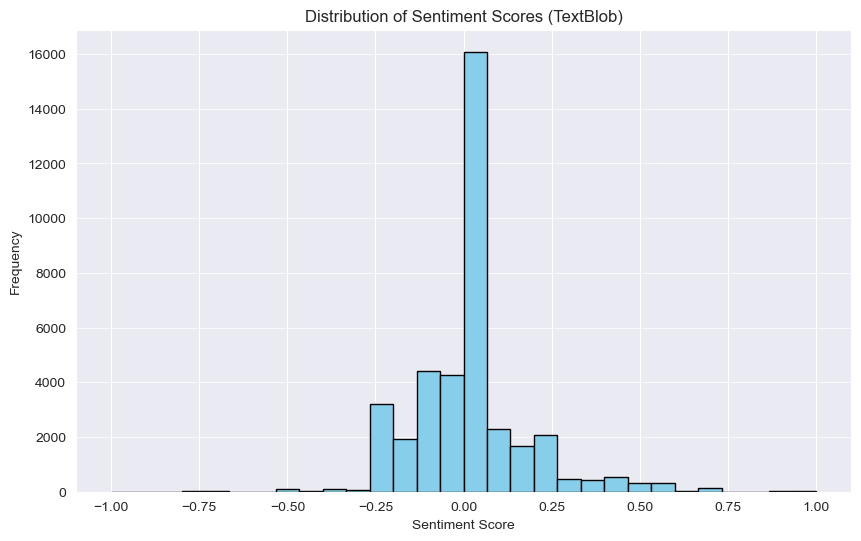

In [25]:
# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(df_textblob_3['TextBlob_Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores (TextBlob)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#### Distribution of the 3 categories, for 2 different approaches

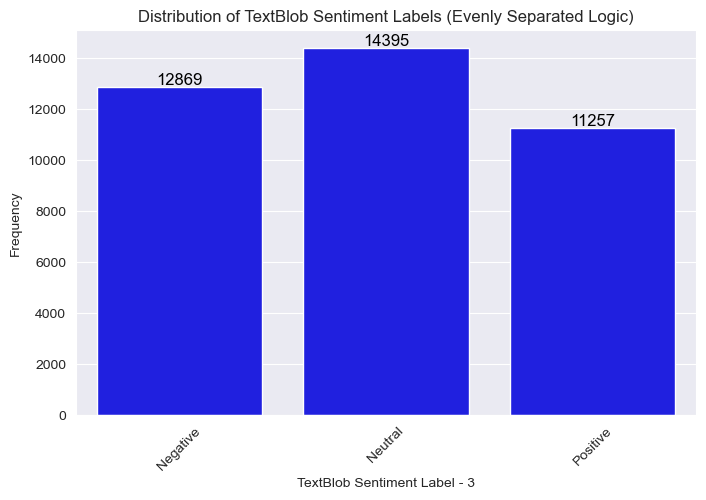

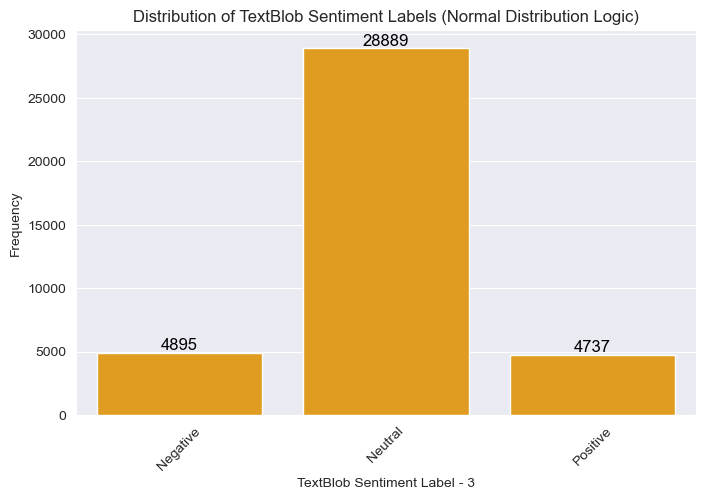

In [26]:
# Define the order of sentiment labels
sentiment_order = ['Negative', 'Neutral', 'Positive']

# Create a count plot with a single color for all bars for Evenly Separated Logic
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_textblob_3, x='TextBlob_Evenly_Separated_Label', color='blue', order=sentiment_order)
plt.xlabel('TextBlob Sentiment Label - 3')
plt.ylabel('Frequency')
plt.title('Distribution of TextBlob Sentiment Labels (Evenly Separated Logic)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add the actual frequency values on top of the bars without decimal values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

# Create a count plot with a single color for all bars for Normal Distribution Logic
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_textblob_3, x='TextBlob_Normal_Distribution_Label', color='orange', order=sentiment_order)
plt.xlabel('TextBlob Sentiment Label - 3')
plt.ylabel('Frequency')
plt.title('Distribution of TextBlob Sentiment Labels (Normal Distribution Logic)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add the actual frequency values on top of the bars without decimal values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

#### Distribution of the 5 categories, for 2 different approaches

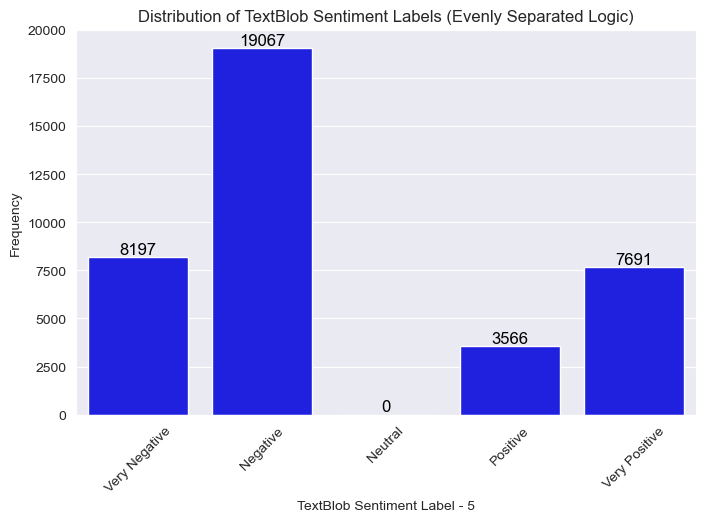

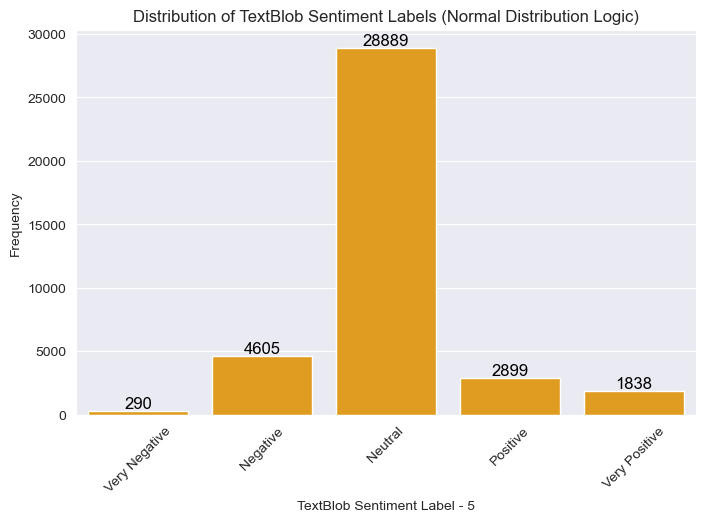

In [21]:
# Define the order of sentiment labels
sentiment_order = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

# Create a count plot with a single color for all bars for Evenly Separated Logic
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_textblob_5, x='TextBlob_Evenly_Separated_Label', color='blue', order=sentiment_order)
plt.xlabel('TextBlob Sentiment Label - 5')
plt.ylabel('Frequency')
plt.title('Distribution of TextBlob Sentiment Labels (Evenly Separated Logic)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add the actual frequency values on top of the bars without decimal values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

# Create a count plot with a single color for all bars for Normal Distribution Logic
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_textblob_5, x='TextBlob_Normal_Distribution_Label', color='orange', order=sentiment_order)
plt.xlabel('TextBlob Sentiment Label - 5')
plt.ylabel('Frequency')
plt.title('Distribution of TextBlob Sentiment Labels (Normal Distribution Logic)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add the actual frequency values on top of the bars without decimal values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

### NLTK (VADER)

In [ ]:
used_approach = "NLTK_VADER" #setting it for later reference

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Record the start time
start_time = time.time()

# Apply sentiment analysis and store the compound score in a new column
df_nltk_3['NLTK_Sentiment'] = df_nltk_3['Cleaned_Text'].apply(lambda text: sia.polarity_scores(text)['compound'])

for i, row in enumerate(df_nltk_3.index):
    text = df_nltk_3.at[row, 'Cleaned_Text']
    sentiment_score = sia.polarity_scores(text)['compound']
    df_nltk_3.at[row, 'NLTK_Sentiment'] = sentiment_score

    # Print progress message
    print(f"Text number {i + 1} out of all {total_rows} rows in the input file: Sentiment score = {sentiment_score}.")

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Define custom thresholds
negative_threshold = -0.33
positive_threshold = 0.33

# Function to categorize sentiment labels based on custom thresholds
def categorize_sentiment(score):
    if score <= negative_threshold:
        return 'Negative'
    elif score <= positive_threshold:
        return 'Neutral'
    else:
        return 'Positive'

# Apply custom labeling method
df_nltk_3['NLTK_Evenly_Separated_Label'] = df_nltk_3['NLTK_Sentiment'].apply(categorize_sentiment)

# Rest of your code for calculating normal distribution labels
mean_score = df_nltk_3['NLTK_Sentiment'].mean()
std_deviation = df_nltk_3['NLTK_Sentiment'].std()

# Calculate the lower and upper thresholds for labeling based on a normal distribution
lower_threshold = mean_score - std_deviation
upper_threshold = mean_score + std_deviation

# Function to categorize sentiment labels based on distribution
def categorize_sentiment(score):
    if score <= lower_threshold:
        return 'Negative'
    elif score <= upper_threshold:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the second labeling method: based on normal distribution
df_nltk_3['NLTK_Normal_Distribution_Label'] = df_nltk_3['NLTK_Sentiment'].apply(categorize_sentiment)

print("-"*100)

In [ ]:
# Calculate hours, minutes, and seconds from the elapsed time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

# Format the elapsed time string
elapsed_time_str = f"{hours} hours, {minutes} mins, and {seconds} secs"

# End information about the run
print(f"The used approach was {used_approach}.")
print(f"Elapsed time: {elapsed_time_str}.")

In [ ]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_nltk = os.path.join(output_folder, 'sentiment_results_nltk.xlsx')
df_nltk_3.to_excel(excel_output_file_nltk, index=False)

# Save the results to a csv file with the same name
csv_output_file_nltk = os.path.join(output_folder, 'sentiment_results_nltk.csv')
df_nltk_3.to_csv(csv_output_file_nltk, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_nltk} and {excel_output_file_nltk}.")

### Explorative Analysis of NLTK (VADER)

In [ ]:
# Create a histogram to visualize the distribution of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df_nltk_3['NLTK_Sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of NLTK Sentiment Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add mean and standard deviation lines to the plot
mean_score = np.mean(df_nltk_3['NLTK_Sentiment'])
std_deviation = np.std(df_nltk_3['NLTK_Sentiment'])
plt.axvline(x=mean_score, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(x=mean_score + std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean + Std Dev')
plt.axvline(x=mean_score - std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean - Std Dev')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Create subplots for the two countplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Define the order of sentiment labels
sentiment_order = ['Negative', 'Neutral', 'Positive']

# Create countplots for Evenly Separated Logic
sns.countplot(data=df_nltk_3, x='NLTK_Evenly_Separated_Label', color='blue', order=sentiment_order, ax=axes[0])
axes[0].set_xlabel('NLTK Evenly Separated Label')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of NLTK Evenly Separated Sentiment Labels')

# Create countplots for Normal Distribution Logic
sns.countplot(data=df_nltk_3, x='NLTK_Normal_Distribution_Label', color='orange', order=sentiment_order, ax=axes[1])
axes[1].set_xlabel('NLTK Normal Distribution Label')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of NLTK Normal Distribution Sentiment Labels')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Merge Results

In [ ]:
# Merge the two dataframes based on Row_Number
merged_df = pd.merge(df_textblob_3, df_nltk_3, on='Row_Number', how='inner')

# Select the common columns from one of the original dataframes (e.g., df_textblob)
common_columns = ['Row_Number', 'Unternehmen', 'Newstyp', 'Quelle', 'Nearest_Date', 'Cleaned_Text', 'Stock_Value']

# Merge the common columns with the merged sentiment columns
df_combined = df_textblob_3[common_columns].merge(merged_df, on='Row_Number', how='inner')

# Drop not needed, duplicated columns
columns_to_drop = ['Unternehmen_x', 'Newstyp_x', 'Quelle_x', 'Nearest_Date_x', 'Cleaned_Text_x', 'Stock_Value_x',
                   'Unternehmen_y', 'Newstyp_y', 'Quelle_y', 'Nearest_Date_y', 'Cleaned_Text_y', 'Stock_Value_y']
df_combined = df_combined.drop(columns_to_drop, axis=1)

# Display the merged dataframe
print(df_combined.head())

In [ ]:
# Saving the output in two file formats in dedicated files for only this current approach in the correct repository folder

# Save the results to an Excel file
excel_output_file_combined = os.path.join(output_folder, 'sentiment_results_combined.xlsx')
df_combined.to_excel(excel_output_file_combined, index=False)

# Save the results to a csv file with the same name
csv_output_file_combined = os.path.join(output_folder, 'sentiment_results_combined.csv')
df_combined.to_csv(csv_output_file_combined, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_combined} and {excel_output_file_combined}.")

In [ ]:
# Analysing similarities in the labels
same_labels_count = (df_combined['TextBlob_Evenly_Separated_Label'] == df_combined['NLTK_Evenly_Separated_Label']).sum()

total_rows = len(df_combined)

percentage_same_labels = (same_labels_count / total_rows) * 100

print(f"Percentage of rows where TextBlob and NLTK have the same Evenly Separated Label: {percentage_same_labels:.2f}%")

# Now for the normal distribution
same_labels_count = (df_combined['TextBlob_Normal_Distribution_Label'] == df_combined['NLTK_Normal_Distribution_Label']).sum()

total_rows = len(df_combined)

percentage_same_labels = (same_labels_count / total_rows) * 100

print(f"Percentage of rows where TextBlob and NLTK have the same Normal_Distribution_Label: {percentage_same_labels:.2f}%")